# Example MCMC analysis

This tutorial will go through running a likelihood analysis with CCL. It will compare "data" and "model" angular shear power spectra, to infer values for the $\Omega_c$ and $\sigma_8$ parameters.

In [2]:
import emcee # MCMC package http://dan.iel.fm/emcee/current/
%pylab inline
import pyccl as ccl

# for nicer plots http://seaborn.pydata.org -- optional
# if you don't want to use it, you can comment this and the next line
import seaborn as sns; sns.set_style('darkgrid')
sns.set_context("talk")

pylab.rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


## The "Data"

Let's create the "data" in the form of $C_\ell$ As a proof of point, we'll make the "data" using CCL (as a proof of concept $-$ normally you will want to input your real data here).

### First, we have to define a redshift distribution:

In [3]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

ell = np.arange(2, 2000)
delta_ell = ell[1]-ell[0]
Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

Now let's set the cosmological parameters for our "data" and create it as an angular shear $C_\ell$

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96,  sigma8=0.83, transfer_function='bbks')

tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell) #C_ell

A simple plot to see how this looks:

Text(0, 0.5, '$C_\\ell$')

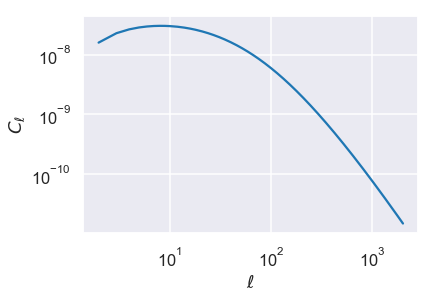

In [6]:
plt.plot(ell,data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

## Make a covariance matrix:
For the purpose of demonstration, we'll simply make a simplified diagonal covariance matrix without shape noise. Again you will want to input the actual covariance matrix here.

In [7]:
# C_ell^2/(Area of LSST survey*ell*delta ell)
cov = np.diag(data**2)*2*np.pi/((4*np.pi*18000)*(np.pi/180)**2*ell*delta_ell) 
icov = np.linalg.inv(cov) #inverse of cov

## Run the MCMC:

Let's define our model that we want to test against our data. We'll use the same redshift distribution as above.

We will define `ln(probability)` (easier computationally that `probability`). Theta is the set of $\Omega_c$ and $\sigma_8$

For the likelihood analysis, we'll use MCMC to find the set of parameters that minimises $\chi^2 =(d - t)^T \cdot \Sigma^{-1} \cdot (d-t)$, with $\Sigma$: the covariance matrix $d$: data, and $t$: theory. The likelihood is then $L = e^{- \chi^2 / 2}$


In [8]:
def lnprob(theta):
    for i in range(len(theta)):
        cosmo = ccl.Cosmology(
            Omega_c=theta[0], Omega_b=0.045, h=0.67, n_s=0.96, sigma8=theta[1], 
            transfer_function='bbks')
        
        tracer1 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
        tracer2 = ccl.WeakLensingTracer(cosmo,dndz=(z,dNdz))
        model = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
        diff = data-model
    return -np.dot(diff,np.dot(icov,diff))/2.0

We'll sample a 2-dimensional Gaussian

In [9]:
ndim = 2

Choose an initial set of positions for the walkers as a 2-d gaussian around some reasonable values:

In [10]:
nwalkers = 10
p0 = [np.array([0.27,0.83])*np.ones(ndim)+np.array([0.05,0.1]) * numpy.random.rand() for i in range(nwalkers)] 
p0 = np.array(p0)
p0 = p0 - len(p0)*[[0.025,0.05]]

Initialize the sampler with the chosen specs.

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run 50 steps as a burn-in

In [12]:
%time pos, prob, state = sampler.run_mcmc(p0, 50)

CPU times: user 4min 30s, sys: 18.1 s, total: 4min 48s
Wall time: 4min 2s


Reset the chain to remove the burn-in samples

In [13]:
sampler.reset()

Starting from the final position in the burn-in chain, sample for 100 steps

In [14]:
sampler.run_mcmc(pos, 100, rstate0=state); 

Print out the mean acceptance fraction. In general, acceptance_fraction has an entry for each  walker so, in this case, it is a 10-dimensional vector.

In [15]:
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

Mean acceptance fraction: 0.725


Get the samples from the results to plot them later:

In [16]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

Results as mean and $95\%$ Confidence interval of $\Omega_c$ and $\sigma_8$:

In [17]:
map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))

Results as a contour plot of the two parameters $-$ $\Omega_c$ and $\sigma_8$:

/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


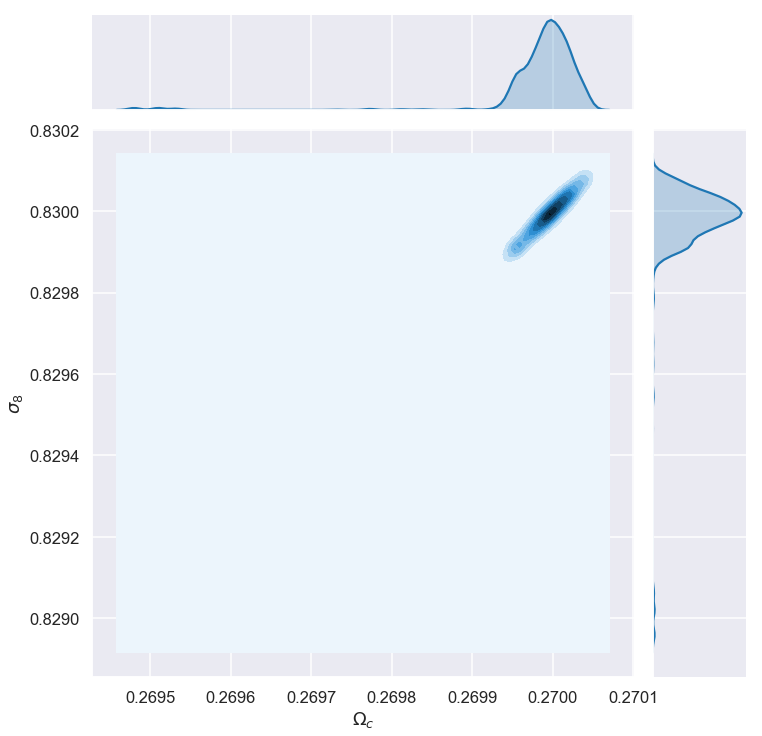

In [18]:
sns.jointplot(
    samples[:,0],
    samples[:,1],
    kind='kde',
    stat_func=None,
    height=10).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")